## First import some necessary packages

In [1]:
import logging
import os
import pathlib

import colorcet as cc
import geopandas as gpd
import holoviews as hv
import hvplot.pandas  # noqa: API import
import hvplot.xarray  # noqa: API import
import ipyleaflet
import numpy as np
import pandas as pd
import panel as pn

from bokeh.models import PanTool, WheelZoomTool, HoverTool

from random import shuffle, uniform

import IPython
import ipywidgets as widgets
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from ipywidgets import interact
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import MultipleLocator

# Activate Panel extension to make interactive visualizations
pn.extension()

In [2]:
# # Read questions from cloud storage

# import coastal_dynamics as cd

# questions = cd.read_questions(
#     "az://coastal-dynamics/questions/5_morphodynamics_upper_shoreface.json",
#     storage_options={"account_name": "coclico"},
# )

# Morphodynamics of the upper shoreface
Welcome to the notebook of week 5! The main topic of this notebook is beach states (section 7.3 in the book). These are discussed also in the context of coastal classification (chapter 2 in the book). This notebook consists of the following sections:
* Coastal classification
* Beach states

Each section contains questions for you to practice with (cross-shore) sediment transport. Let's get started!

## Coastal classification
As you know from chapter 2 of the book and the week 1 notebook, coasts can be classified based on tectonics and processes. In this notebook we will look at different Brazilian beaches, and try to classify them. Let's start with loading the dataset with data for Brazilian beaches. This dataset contains the significant wave height (Hs), the peak period (T), the mean tidal range (MTR), and the coastal slope for different coordinates along the Brazilian coast.(adapted from https://zenodo.org/records/8200200). Specifically, we will take a look at the Brazilian province Santa Catarina. This coastal province can be subdivided in five different regions. For simplicity, we will work with the mean grain size of sediment (D) for each of these regions, which is also included in the dataset.

### Load data

In [3]:
fpath = pathlib.Path("C:/Users/khdeb/Documents/Mijn Documenten/werk/TA Coastal and Estuarine Systems/Content development/actual development/week 5/")
fname = "brazilian_coast.gpkg"
# We load this file as a GeoDataFrame, which comes with a column containing the geometry of each entry. For this dataset, these are points (longitude, latitude)
gdf = gpd.read_file(os.path.join(fpath, fname))
display(gdf.head())

# Let's also load in some beaches, and their locations
beaches = (
    # ("name", "latitude", "longitude"),
    ("Campo Bom", -28.7238889, -049.0613889),
    ("Laguna", -28.4813889, -048.7650000),
    ("Enseada da Pinheira", -27.8658333, -048.6019444),
    ("Praia do Moçambique", -27.5313889, -048.4208333),
    ("Tijucas", -27.233117536346906, -48.61195557330283),
    ("Balneário Camboriú", -26.99587680030832, -48.623795816849324),
    ("Do Ubatuba", -26.197513121303377, -48.526129178088894),
    ("Barra Velha", -26.586511049944388, -48.667347851199345)
)

beaches_df = pd.DataFrame(data=beaches, columns=['name', 'lat', 'lon'])
beaches_df.head()

,Region,Hs [m],MTR [m],T [s],D [mm],nearshore slope [degrees],geometry
0,Region 1,0.78,1.462,7.95,0.3,0.154125,POINT (-48.60344 -26.00940)
1,Region 1,0.78,1.458,7.95,0.3,0.446898,POINT (-48.60532 -26.01826)
2,Region 1,0.78,1.454,7.96,0.3,0.582678,POINT (-48.60689 -26.02717)
3,Region 1,0.78,1.451,7.96,0.3,0.544294,POINT (-48.60809 -26.03613)
4,Region 1,0.78,1.447,7.96,0.3,0.605021,POINT (-48.60859 -26.04514)


,name,lat,lon
0,Campo Bom,-28.723889,-49.061389
1,Laguna,-28.481389,-48.765000
2,Enseada da Pinheira,-27.865833,-48.601944
3,Praia do Moçambique,-27.531389,-48.420833
4,Tijucas,-27.233118,-48.611956


### Define plot function

**Note**: Although you don't have to understand the plot method, we include it here so you can see how these interactive plots are made! !

In [4]:
def plot_brazilian_coast(plot_where='pop-out'):
    """
    change value of 'plot_where' to:
    'inline' if you would like the plot to show in the notebook
    'pop-out' if you would like the plot to show in a new tab (i.e. seperate window)
    """
    
    # below we build the widget
    title_bar = pn.Row(
        pn.pane.Markdown("## Brazilian beaches",
                         styles={"color": "black"},
                         sizing_mode="fixed",
                         margin=(10,5,10,15),
        ),
        align='center',
    )

    # dropdown menu of beaches
    options = beaches_df.name.to_list()
    beaches_dropdown = pn.widgets.Select(
        name="Beach", options=options, value=np.random.choice(options))

    @pn.depends(beaches_dropdown.param.value)
    def plot_beaches(name, plot_size=0.04):
        
        beach = beaches_df.loc[beaches_df['name']==name].copy()
        lat, lon = beach[['lat', 'lon']].values.flatten()
        lat, lon = np.float64(lat), np.float64(lon)
    
        points = gdf.hvplot.points(
            geo=True,
            tiles='ESRI',
            ylabel='Latitude [deg]',
            xlabel='Longitude [deg]',
            xlim=(lon-plot_size/2, lon+plot_size/2),
            ylim=(lat-plot_size/2, lat+plot_size/2),
            tools=['tap'],
            hover_cols=["Longitude", "Latitude", "Region", "Hs [m]", "MTR [m]", "T [s]", "D [mm]", "nearshore slope [degrees]"],
            c='Region',
            cmap='Accent',
            line_color='black',
            size=300,
            )
    
        plot = (points).opts(
            width=800,
            height=800,
            tools=['wheel_zoom']
            )
        return plot

    app = pn.Column(pn.Row(title_bar, align="center"),
                    pn.Row(beaches_dropdown, align="center"),
                    pn.Row(plot_beaches, align="center"))

    if plot_where == "inline":
        return app
    elif plot_where == "pop-out":
        app.show()
    else:
        print("please use either inline or pop-out for the plot_where variable")

### Now plot the coastal data

Execute the cell below to generate the plot by using the function we defined above. Please note that altering the slider positions or selecting different options from the dropdown menus may trigger a warning; it can safely be ignored, and possibly silenced by the adjusting the logging warning level. 

In [5]:
logging.getLogger().setLevel(logging.ERROR)

plot_brazilian_coast(plot_where="pop-out")

Launching server at http://localhost:52950


C:\Users\khdeb\mambaforge\envs\coastal\Lib\site-packages\holoviews\core\util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)


Have a look at section 4.4.2 from the book, and figure 4.13. Let's try to classify some of the beaches using the mean tidal range and mean wave height! Let's plot some of the brazilian beaches and see how they are classified using the figure. Use the brazilian beaches plot to determine relevant values for the mean tidal range and the mean wave height.

In [6]:
# Define points here

data = (
    # ("label", mean wave height [m], mean tidal range [m]),
    ("Campo Bom", 1.590, 0.581),
    ("Laguna", 1.45, 0.53),
    ("Do Ubatuba", 0.8, 1.364),
    ("...", 0.78, 1.462)
)

df = pd.DataFrame(data, columns=('label', 'Hs', 'MTR'))
df.head()

,label,Hs,MTR
0,Campo Bom,1.59,0.581
1,Laguna,1.45,0.530
2,Do Ubatuba,0.80,1.364
3,...,0.78,1.462


**Note**: Although you don't have to understand the plot method, we include it here so you can see how these interactive plots are made!

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
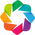

C:\Users\khdeb\mambaforge\envs\coastal\Lib\site-packages\holoviews\core\util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)


:Overlay
   .RGB.I       :RGB   [x,y]   (R,G,B)
   .NdOverlay.I :NdOverlay   [label]
      :Points   [Hs,MTR]

In [7]:
hv.extension('bokeh')

# Load background
image_name = "4_graph_relationship-mean-tidal-range-wave-height_custom.jpg"
bg = hv.RGB.load_image(os.path.join(fpath, image_name), bounds=(0,0,2.5,6)).opts(alpha=0.5)

# create the points
points = df.hvplot.points(x='Hs', y='MTR', by='label', size=100,
            cmap='Accent',
            line_color='black')

fig413 = (bg*points).opts(width=600, height=600, show_grid=True, active_tools=[], toolbar=None, xlabel='mean wave height [m]', ylabel='mean tidal range [m]', xlim=(0,2.5), ylim=(0,6), show_legend=True)

fig413

Using this figure, and the brazilian beaches plot, answer the questions below.

In [8]:
# # Start with wave-dominated beaches
# - features of beaches they see in the plot
# - compare two beaches
# - ask reflective questions about why some beach with higher tidal range can still be wave dominated
# - ask about barrier islands
# - ask about value for some beach, and whether they expect it to be accurate
# - ask if they see vegetation, and what this indicates w.r.t. dominant process
# - 

This is the end of the first part of this notebook. You can continue with the next part on beach states!

## Beach states
From section 7.3 from the book, you know that a wave-dominated beach may be classified as reflective or dissipative, or an intermediate state in between. A common classifier used besides the Iribarren number is the dimensionless fall velocity, which is calculated as follows: \
$$
\Omega = \frac{H_b}{w_s T}
$$
where $H_b$ is the wave height at breaking, $T$ is the wave period and $w_s$ is the fall velocity. \
\
With data on wave height at breaking being limited, let's be pragmatic and use the beach slope as a proxy for classifying a beach as being dissipative, intermidate, or reflective. We can get the beach slope data from the same dataset as used above.

Finish the code below with some of the beaches to show where they would lie in figure 7.10.

In [9]:
data = (
    # ("label", slope [degrees], mean diameter [mm]),
    ("Campo Bom", 2.987, 0.21),
)

data = zip(gdf['nearshore slope [degrees]'], gdf['D [mm]'])

# df = pd.DataFrame(data=data, columns=['label', 'slope [degrees]', 'D [mm]'])
df = pd.DataFrame(data=data, columns=['nearshore slope [degrees]', 'D [mm]'])

df.head()

,nearshore slope [degrees],D [mm]
0,0.154125,0.3
1,0.446898,0.3
2,0.582678,0.3
3,0.544294,0.3
4,0.605021,0.3


In [10]:
points = df.hvplot.points(x='nearshore slope [degrees]', y='D [mm]', size=10)

hlines = (hv.HLine(0.25).opts(color='lightgrey') * hv.HLine(0.5).opts(color='lightgrey'))
vlines = (hv.VLine(3.5).opts(color='lightgrey') * hv.VLine(8.5).opts(color='lightgrey')).opts(border_line_color='lightgrey')

classify_labels = hv.Text(1.75, 0.95, "dissipative", fontsize=10) * \
                  hv.Text(6, 0.95, "intermediate", fontsize=10) * \
                  hv.Text(13, 0.95, "reflective", fontsize=10)

grain_labels = hv.Text(15.8, 0.75, "coarse sand", fontsize=10, halign='right') * \
               hv.Text(15.8, 0.375, "medium sand", fontsize=10, halign='right') * \
               hv.Text(15.8, 0.125, "fine sand", fontsize=10, halign='right')


(
    points * hlines * vlines * classify_labels * grain_labels
).opts(ylim=(0, 1), xlim=(0, 16))

C:\Users\khdeb\mambaforge\envs\coastal\Lib\site-packages\holoviews\core\data\pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
C:\Users\khdeb\mambaforge\envs\coastal\Lib\site-packages\holoviews\core\data\pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Points.I :Points   [nearshore slope [degrees],D [mm]]
   .HLine.I  :HLine   [x,y]
   .HLine.II :HLine   [x,y]
   .VLine.I  :VLine   [x,y]
   .VLine.II :VLine   [x,y]
   .Text.I   :Text   [x,y]
   .Text.II  :Text   [x,y]
   .Text.III :Text   [x,y]
   .Text.IV  :Text   [x,y]
   .Text.V   :Text   [x,y]
   .Text.VI  :Text   [x,y]

Start with looking at beaches in Northern brazil to see some tide dominated systems (at Sao Luis, Maranhao and/or Para)s

cherry pick some beaches from the dataset to see nice examples (and anomalies)

Add button to only plot specific beaches

Calculate dimensionless fall velocity (with Hs)

Make picture for MTR to Hs more like the book

start with global data for tide vs wave, the move to Klein paper for beach states (and compare with global data) (papers are in 9-1-2024 meeting folder)--> or other way arounds

maybe join next week tutorial for small update meeting